**Part 2**

## Transform sentences to sequences

First, we need to import packages for modelling, as well as loading the Word2Vec model and the preprocessed datasets we have done in part 1:

In [1]:
# Mute warning for better reading
import warnings
from tensorflow.compat.v1 import logging
warnings.filterwarnings('ignore')
logging.set_verbosity(logging.ERROR)

# Data loading and manipulation
import pickle
import numpy as np

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# Sklearn metric tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the data from pickle
trigrams_model = pickle.load(open('resources/trigrams_model.pickle', 'rb'))
train = pickle.load(open('resources/trainset.pickle', 'rb'))
test = pickle.load(open('resources/testset.pickle', 'rb'))

X_train, Y_train = train[0], train[1]
X_test, Y_test = test[0], test[1]

Using TensorFlow backend.


With the sentences-with-n-grams, we can vetorize our sentences and later transforming them into sequences for training the model.

In [2]:
%%time
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

input_length = 150
X_train_pad = pad_sequences(
    sequences=vectorize_data(X_train, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Vectorize sentences... (done)
Transform sentences to sequences... (done)
Wall time: 5min 55s


## Building the model using BiLSTM

We are going to use Bidirectional LSTMs (BiLSTM), which is one of the RNN architectures for deep learning that are used in occasions where the learning problem is sequential. As the movie reviews are naturally sequential, we can try using this technique to train our model to predict whether it is possitive or not.

In BiLSTM, it involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second. It usually learns faster than one-directional approach.

So here let's define and configure how the model will work:

In [3]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    # Embedding layer (lookup table of trainable word vectors)
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    # Bidirectional LSTMs layer
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    # Dropout and Dense twice
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    # Give out a summary
    model.summary()
    return model

model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 256)          23625472  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 24,036,225
Trainable params: 410,753
Non-trainable params: 23,625,472
__________________________________________________________

Before we start feeding the model with our training data set, let's split some data from the training set to build a validation set.

The idea of making this validation set for the model is that we can judge how well the model can generalize. Meaning, how well can the model able to predict on data that it's not seen while being trained.

The model does not "see" our validation set and is not in any way trained on it, but we as the architect and master of the hyperparameters tune the model according to this data. Therefore it indirectly influences the model because it directly influences our design decisions.

So here we use sklearn to split 5% of the training data for validation.

In [4]:
x_feed, x_valid, y_feed, y_valid = train_test_split(
    X_train_pad,
    Y_train,
    test_size=0.05,
    shuffle=True,
    random_state=42)

And let's feed in data and start training it!

In [5]:
# Here we use adam optimizer
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

# And we train the model for 20 epochs
# (could be run as many times as needed, 20 might be enough in this case)
history = model.fit(
    x=x_feed,
    y=y_feed,
    validation_data=(x_valid, y_valid),
    batch_size=100,
    epochs=20)

Train on 23750 samples, validate on 1250 samples
Epoch 1/20
23750/23750 [==============================] - 183s 8ms/step - loss: 0.6508 - acc: 0.6155 - val_loss: 0.5438 - val_acc: 0.7456
Epoch 2/20
23750/23750 [==============================] - 178s 8ms/step - loss: 0.5687 - acc: 0.7145 - val_loss: 0.5190 - val_acc: 0.7648
Epoch 3/20
23750/23750 [==============================] - 176s 7ms/step - loss: 0.4996 - acc: 0.7656 - val_loss: 0.4613 - val_acc: 0.7824
Epoch 4/20
23750/23750 [==============================] - 185s 8ms/step - loss: 0.4439 - acc: 0.7956 - val_loss: 0.4446 - val_acc: 0.7920
Epoch 5/20
23750/23750 [==============================] - 207s 9ms/step - loss: 0.3942 - acc: 0.8281 - val_loss: 0.4219 - val_acc: 0.8224
Epoch 6/20
23750/23750 [==============================] - 231s 10ms/step - loss: 0.3501 - acc: 0.8477 - val_loss: 0.4065 - val_acc: 0.8312
Epoch 7/20
23750/23750 [==============================] - 252s 11ms/step - loss: 0.3153 - acc: 0.8657 - val_loss: 0.4096 -

Above we can see that we are getting a 80% accuracy with around 4% loss after 20 epoch, which is overall pretty good.

In [7]:
# Save our model and the training history to the dir (so we may refer it back later)
model.save('my_model.h5')
pickle.dump(history.history, open('resources/history', 'wb'))

## Model performance

Before we check how our model perform, let's also transfrom the testing data:

In [8]:
%%time
X_test_pad = pad_sequences(
    sequences=vectorize_data(X_test, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Vectorize sentences... (done)
Transform sentences to sequences... (done)
Wall time: 7min 15s


Now, let's use our model to predict the sentiment of the movie reviews. We use the training data predictions as a comparison with the testing data predictions. Then we show both results with sklearn classification report.

In [10]:
%%time
# Predict using training and testing data respectively
Y_train_pred = model.predict_classes(X_train_pad)
Y_test_pred = model.predict_classes(X_test_pad)

Wall time: 3min 1s


In [21]:
from sklearn.metrics import classification_report

# Train data report (for comparison)
print(classification_report(Y_train_pred, Y_train))
# Test data report (real thing)
print(classification_report(Y_test_pred, Y_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     12766
           1       0.97      0.99      0.98     12234

    accuracy                           0.98     25000
   macro avg       0.98      0.98      0.98     25000
weighted avg       0.98      0.98      0.98     25000

              precision    recall  f1-score   support

           0       0.88      0.74      0.80     14881
           1       0.69      0.85      0.76     10119

    accuracy                           0.78     25000
   macro avg       0.78      0.79      0.78     25000
weighted avg       0.80      0.78      0.79     25000



As we can see, we reach an accuracy of 78% with the testing dataset in the final. And let's see how the training progress goes:

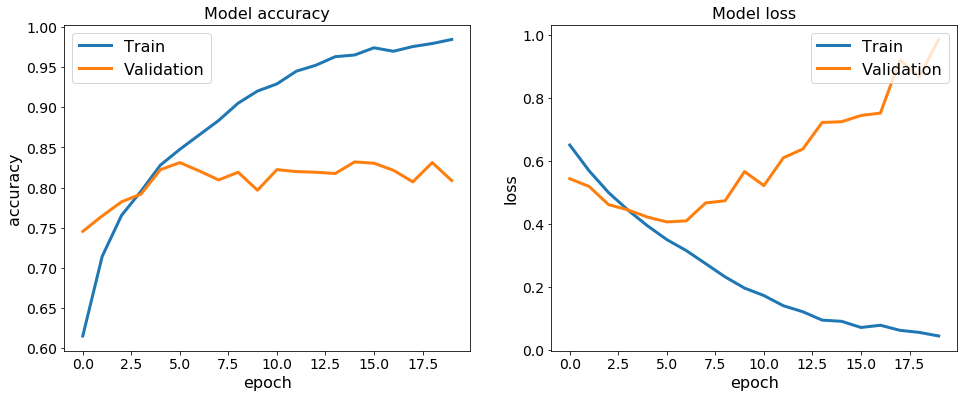

In [22]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['acc'], label='Train', linewidth=3)
axis1.plot(history.history['val_acc'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

It is still possible to try out different parameters which may lead to better result. And if possible, we can find more dataset to train that may imporve this model.

---
**End**